Mounted at /content/gdrive


Text(0.5, 0, 'Strain')

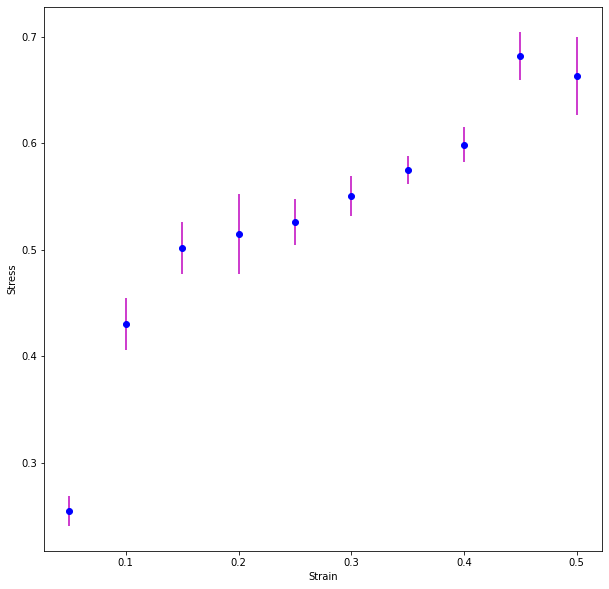

In [3]:
# Display Data
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd

# Read the csv file using pandas
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/MDM project/MData.csv')

# Convert the dataframe to a 3D numpy array
array_3d = np.array([df.values.tolist()])
strain = array_3d[0,:,0]
stress = array_3d[0,:,1]
sd = array_3d[0,:,2]

import matplotlib.pyplot as plt
#Plot Strain-Stress Scatter Graph.
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m')
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

In [4]:
from pylab import * 
import scipy.optimize

def uniaxial_stress(model, trueStrainVec, params):
 """Compressible uniaxial loading. Returns true stress. 
 N: "ture" means add a exp() term on the strain.
 N: model() calls the hyperelastic model, defined below."""
 stress = zeros(len(trueStrainVec))
 for i in range(len(trueStrainVec)):
  lam1 = 1+trueStrainVec[i] #N: convert strain to stretch
  #print(lam1)
  x0 = 1/sqrt(lam1)
  #print(x0)

  calcS22Abs = lambda x: abs( model(lam1,x,x,params)[1,1] )
  #N:The calcS22Abs function is a lambda function that takes 
  #one argument x and returns the absolute value of 
  #the element S22 of the stress tensor, computed by the 
  #model function for a given stretch tensor [lam1,x,x] and params.

  #N:[1,1] is used to access the element in the second row 
  #and second column of the stress tensor (S22)

  # search for transverse stretch that gives S22=0
  lam2 = scipy.optimize.fmin(calcS22Abs, x0,
                 xtol=1e-9, ftol=1e-9, disp=False)
  #N: it uses "fmin" to find the unkown two strains, starting
  #the loop with J=1 (x0=1/sqrt(lam1)),instead of defining a 
  #new variable J.

  stress[i] = model(lam1,lam2,lam2, params)[0,0]
  #N:stores the element S11 in the stress array at 
  #the current strain index i

 return stress

def MR_3D(stretch1,stretch2,stretch3, param):
    """Mooney-Rivlin. 3D loading specified by stretches.
    param: [C10, C01, kappa]"""
    L1 = stretch1
    L2 = stretch2[0]
    L3 = stretch3[0]
    F = array([[L1,0,0], [0,L2,0], [0,0,L3]])
    J = det(F)
    bstar = J**(-2.0/3.0) * dot(F, F.T)
    bstar2 = dot(bstar, bstar)
    I1s = trace(bstar)
    I2s = 0.5 * (I1s**2 - trace(bstar2))
    C10 = param[0]
    C01 = param[1]
    kappa = param[2]
    return 2/J*(C10+C01*I1s)*bstar - 2*C01/J*bstar2 + (kappa*(J-1) - 2*I1s*C10/(3*J) - 4*I2s*C01/(3*J))*eye(3)

In [5]:
# Define Error Esitimation
def percent_error(data, estimated):
  error = 0
  for i in range(len(data)):
    error+=sqrt((data[i]-estimated[i])**2)
  return error/sum(data)

[-1.05860162  1.88424925  1.78288658]


Text(0.5, 0, 'Strain')

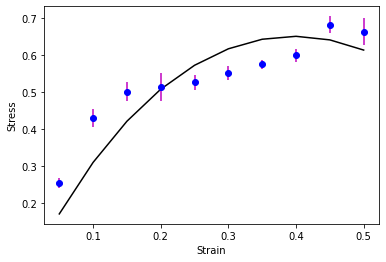

In [6]:
# Determine initial guess by least square root
from scipy.optimize import curve_fit  

def MR_stress(strain, *params):
   stress = uniaxial_stress(MR_3D, strain, params)
   return stress
p0 = 1., 1., 1.
params_opt, params_cov = curve_fit(MR_stress, strain, stress, p0)
#The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. 
print(params_opt)
initial_values = params_opt

#Plot initial guess with least square root method  
stress_initial_guess = uniaxial_stress(MR_3D, strain, initial_values) 
#mu=param[0],k=mu=param[1]

# Fit the data with deterministic model
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m')
ax1.plot(strain, stress_initial_guess, 'k')
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

In [7]:
percent_error(stress,stress_initial_guess)

0.11581055487926212

In [8]:
# Display the covariance matrix
print(params_cov)

[[ 0.22908314 -0.31771472  0.5265395 ]
 [-0.31771472  0.44167535 -0.74608775]
 [ 0.5265395  -0.74608775  1.81488429]]


**Statistic Model** 

Note we are comparing log(likelihood) here to determine each accceptance each iteration, while Hussein's code uses posterior (prior distibution*likelihood).

In [9]:
def likelihood(param, strain, stress, sd):
    stress_e = uniaxial_stress(MR_3D, strain, param)
    l=-np.log(sd * np.sqrt(2* np.pi))-((stress-stress_e)**2) / (2*sd**2)
    log_likelihood = np.sum(l)
    #print(l)
    return log_likelihood

The prior distribution for the model parameters is simply the normal distribution we used to generate the values of E. 

N: The proposal_sd defines the "transition model" between current guess and new guess.

We can then define the MCMC algorithm using the Metropolis-Hastings algorithm:

In [10]:
def metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd):
    n_params = len(initial_values)
    samples = np.zeros((n_iterations, n_params))
    current_values = initial_values
    accepted = np.zeros(n_iterations)
    rejected = np.zeros(n_iterations)
    log_likelihood = np.zeros(n_iterations)
    for i in range(n_iterations):
        # Propose new values
        proposal = current_values + np.random.normal(0, proposal_sds, n_params)
        # Calculate the acceptance ratio
        ratio = np.exp(likelihood(proposal, strain, stress, sd) - likelihood(current_values, strain, stress, sd))
        #print(ratio)
        acceptance_ratio = min(1, ratio)
        log_likelihood[i] = likelihood(proposal, strain, stress, sd)
        # Decide whether to accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
            current_values = proposal
            accepted[i] = 1
        else:
            rejected[i] = 1
        samples[i] = current_values
    return samples, accepted, rejected, log_likelihood

In [11]:
## Section 2; Least Square + MCMC
n_iterations = 5000
proposal_sds = [0.1, 0.1, 0.1]

# Run MCMC algorithm
samples1, accepted1, rejected1, log_likelihood1 = metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd)

In [12]:
accepted_samples = samples1[accepted1==1][:,:]
shape(accepted_samples)

(178, 3)

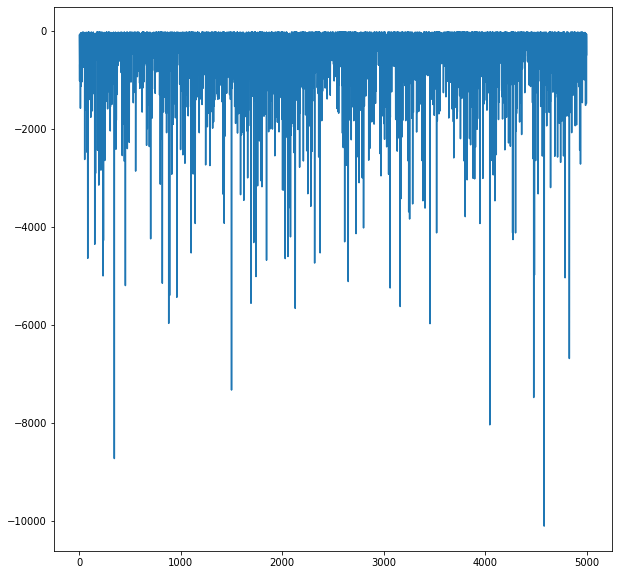

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(log_likelihood1)

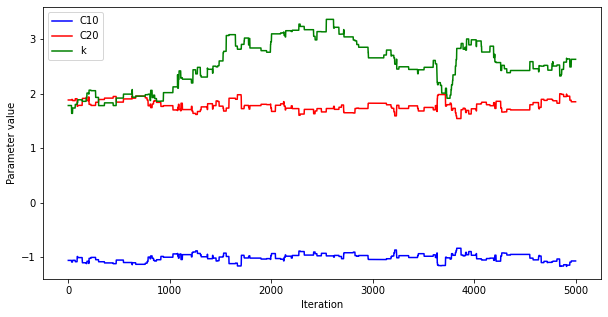

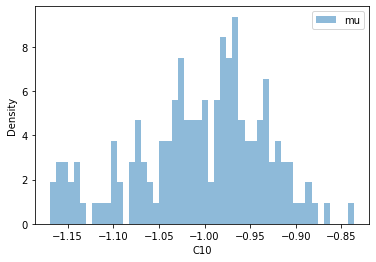

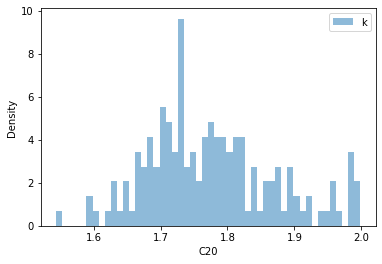

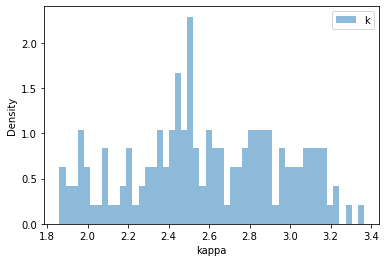

Mean of c10: -1.0049759855545228
Median of c10: -0.9954636659807644
Mean of c20: 1.7755797169104646
Median of c20: 1.7657126893543695
Mean of k: 2.594756326236705
Median of k: 2.5749788352083836
5.0% Confidence interval for c10: [-0.99979812 -0.9884735 ]
5.0% Confidence interval for c20: [1.75612221 1.77148544]
5.0% Confidence interval for k: [2.53403723 2.59418044]
[-1.0049759855545228, 1.7755797169104646, 2.594756326236705]
0.1177458414567153
[-0.9954636659807644, 1.7657126893543695, 2.5749788352083836]
0.11716738116255741
[[ 0.00507967 -0.0069212 ]
 [-0.0069212   0.00951285]]
[-0.97580991  1.72787198  3.36361851]
The Maxmimum Log Likelihood is -25.79
0.11738453382895772


In [14]:
# LSR+MCMC Evaluation 1: MCMC Process Plot (Determine proper burn-in period)
accepted_samples = samples1[accepted1==1][:,:]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(samples1[:, 0],"b-", label="C10")
ax.plot(samples1[:, 1],"r-",label="C20")
ax.plot(samples1[:, 2],"g-",label="k")
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter value")
ax.legend()
plt.show()

# Evaluation 2/3: Select Mean and Median for conparasion
# burnin
to_show = round(0.1*len(accepted_samples))
burnin = to_show
samples_burned_in = accepted_samples[burnin:]
#C10, C20, C30, kappa
# Histogram
plt.figure()
plt.hist(samples_burned_in[:, 0], bins=50, density=True, alpha=0.5, label="mu")
plt.xlabel("C10")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure()
plt.hist(samples_burned_in[:, 1], bins=50, density=True, alpha=0.5, label="k")
plt.xlabel("C20")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure()
plt.hist(samples_burned_in[:, 2], bins=50, density=True, alpha=0.5, label="k")
plt.xlabel("kappa")
plt.ylabel("Density")
plt.legend()
plt.show()


# Select mean/median
mean_C10 = np.mean(samples_burned_in[:, 0])
median_C10 = np.median(samples_burned_in[:, 0])

mean_C20 = np.mean(samples_burned_in[:, 1])
median_C20 = np.median(samples_burned_in[:, 1])

mean_k = np.mean(samples_burned_in[:, 2])
median_k = np.median(samples_burned_in[:, 2])


print("Mean of c10:", mean_C10)
print("Median of c10:", median_C10)
print("Mean of c20:", mean_C20)
print("Median of c20:", median_C20)
print("Mean of k:", mean_k)
print("Median of k:", median_k)

# Confidance Interval
confidence_level = 0.05
lower_percentile = (1 - confidence_level) / 2
upper_percentile = 1 - lower_percentile

CI_C10 = np.percentile(samples_burned_in[:, 0], [lower_percentile * 100, upper_percentile * 100])
CI_C20 = np.percentile(samples_burned_in[:, 1], [lower_percentile * 100, upper_percentile * 100])
CI_K = np.percentile(samples_burned_in[:, 2], [lower_percentile * 100, upper_percentile * 100])

print(f"{confidence_level * 100}% Confidence interval for c10: {CI_C10}")
print(f"{confidence_level * 100}% Confidence interval for c20: {CI_C20}")
print(f"{confidence_level * 100}% Confidence interval for k: {CI_K}")

params_mean = [mean_C10, mean_C20,mean_k]
print(params_mean)
stress_guess = uniaxial_stress(MR_3D, strain, params_mean)
print(percent_error(stress, stress_guess))

params_median = [median_C10, median_C20, median_k]
print(params_median)
stress_guess = uniaxial_stress(MR_3D, strain, params_median)
print(percent_error(stress, stress_guess))

# Evaluation 4: Covariance Metrix
#N: From the MCMC process plot, we already know mu and kappa are negatively correlated.
# Generate two sets of random data
x = accepted_samples[:,0]
y = accepted_samples[:,1]
# Calculate the covariance matrix
covariance_matrix = np.cov(x, y)
print(covariance_matrix)

# Evaluation 5: MLE (max. likelihood estimated)
def estimate_map_point(x, pdf, burn=0):
    x_burned = x[burn:]
    pdf_burned = pdf[burn:]
    return x_burned[np.argmax(pdf_burned)]
MLE_point1 = estimate_map_point(samples1, log_likelihood1, burn=to_show)
print(MLE_point1)
#print("The MLE is {:.2f} GPa".format(MLE_point))
print("The Maxmimum Log Likelihood is {:.2f}".format(max(log_likelihood1)))

stress_guess = uniaxial_stress(MR_3D, strain, MLE_point1)
print(percent_error(stress, stress_guess))

In [15]:
#shape(accepted_samples)

In [16]:
#shape(log_likelihood1)
#print(log_likelihood1)

In [17]:
## Section 3; Run MCMC without the pre-defined initial guess
initial_values = 1.,1.,1.
n_iterations = 5000
proposal_sds = [0.1, 0.1, 0.1]

# Run MCMC algorithm
samples, accepted, rejected, log_likelihood = metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd)

<ipython-input-10-c1e7ff8b895e>:12: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(likelihood(proposal, strain, stress, sd) - likelihood(current_values, strain, stress, sd))


In [18]:
accepted_samples = samples[accepted==1][:,:]
shape(accepted_samples)

(218, 3)

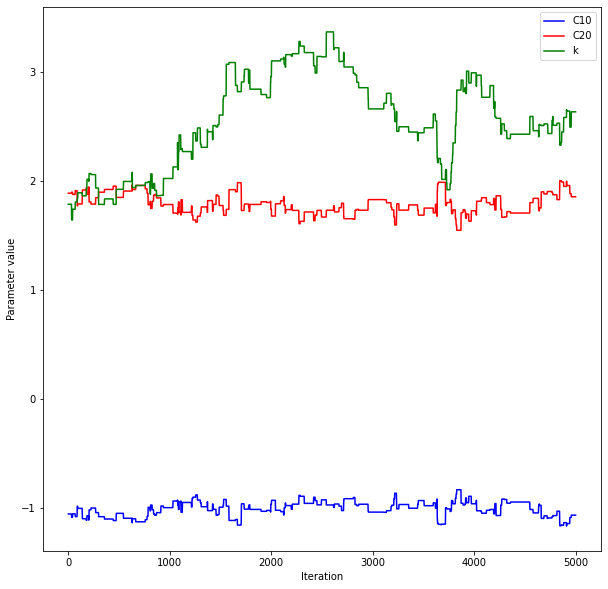

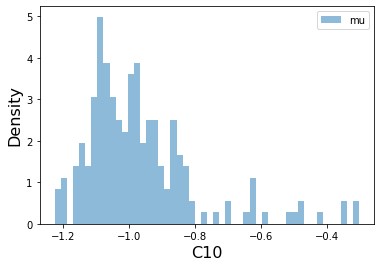

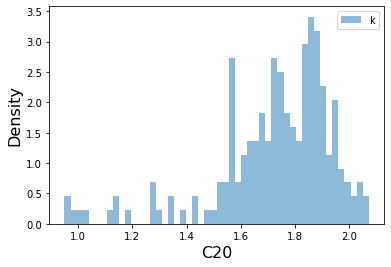

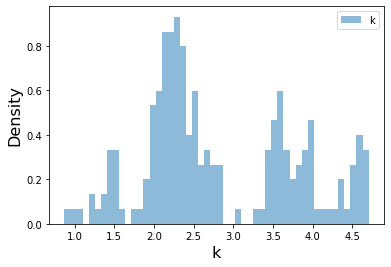

Mean of c10: -0.9673848919483413
Median of c10: -0.9981101040181759
Mean of c20: 1.7282824506834995
Median of c20: 1.7673540843410516
Mean of k: 2.800604364784815
Median of k: 2.4607324456555086
5.0% Confidence interval for c10: [-1.00731054 -0.991458  ]
5.0% Confidence interval for c20: [1.75479321 1.77774445]
5.0% Confidence interval for c30: [2.40642732 2.52423032]
[-0.9673848919483413, 1.7282824506834995, 2.800604364784815]
0.1162072917534648
[-0.9981101040181759, 1.7673540843410516, 2.4607324456555086]
0.11761494935586125
[[ 0.16947295 -0.10851722]
 [-0.10851722  0.08823012]]
[-0.94319993  1.67684418  4.65783525]
The Maxmimum Log Likelihood is -24.98
0.1167654746092779


In [19]:
# MCMC only Evaluation 1: MCMC Process Plot (Determine proper burn-in period)
font = {'size': 16}
accepted_samples = samples[accepted==1][:,:]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(samples1[:, 0],"b-",label="C10")
ax.plot(samples1[:, 1],"r-",label="C20")
ax.plot(samples1[:, 2],"g-",label="k")
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter value")
ax.legend()
plt.show()

# Evaluation 2/3: Select Mean and Median for conparasion
# burnin
to_show = round(0.1*len(accepted_samples))
burnin = to_show
samples_burned_in = accepted_samples[burnin:]
#C10, C20, C30, kappa
# Histogram
plt.figure()
plt.hist(samples_burned_in[:, 0], bins=50, density=True, alpha=0.5, label="mu")
plt.xlabel("C10",fontdict=font)
plt.ylabel("Density",fontdict=font)
plt.legend()
plt.show()

plt.figure()
plt.hist(samples_burned_in[:, 1], bins=50, density=True, alpha=0.5, label="k")
plt.xlabel("C20",fontdict=font)
plt.ylabel("Density",fontdict=font)
plt.legend()
plt.show()

plt.figure()
plt.hist(samples_burned_in[:, 2], bins=50, density=True, alpha=0.5, label="k")
plt.xlabel("k",fontdict=font)
plt.ylabel("Density",fontdict=font)
plt.legend()
plt.show()

# Select mean/median
mean_C10 = np.mean(samples_burned_in[:, 0])
median_C10 = np.median(samples_burned_in[:, 0])

mean_C20 = np.mean(samples_burned_in[:, 1])
median_C20 = np.median(samples_burned_in[:, 1])

mean_k = np.mean(samples_burned_in[:, 2])
median_k = np.median(samples_burned_in[:, 2])


print("Mean of c10:", mean_C10)
print("Median of c10:", median_C10)
print("Mean of c20:", mean_C20)
print("Median of c20:", median_C20)
print("Mean of k:", mean_k)
print("Median of k:", median_k)
# Confidance Interval
confidence_level = 0.05
lower_percentile = (1 - confidence_level) / 2
upper_percentile = 1 - lower_percentile

CI_C10 = np.percentile(samples_burned_in[:, 0], [lower_percentile * 100, upper_percentile * 100])
CI_C20 = np.percentile(samples_burned_in[:, 1], [lower_percentile * 100, upper_percentile * 100])
CI_K = np.percentile(samples_burned_in[:, 2], [lower_percentile * 100, upper_percentile * 100])
print(f"{confidence_level * 100}% Confidence interval for c10: {CI_C10}")
print(f"{confidence_level * 100}% Confidence interval for c20: {CI_C20}")
print(f"{confidence_level * 100}% Confidence interval for c30: {CI_K}")
params_mean = [mean_C10, mean_C20,mean_k]
print(params_mean)
stress_guess = uniaxial_stress(MR_3D, strain, params_mean)
print(percent_error(stress, stress_guess))

params_median = [median_C10, median_C20,median_k]
print(params_median)
stress_guess = uniaxial_stress(MR_3D, strain, params_median)
print(percent_error(stress, stress_guess))

# Evaluation 4: Covariance Metrix
#N: From the MCMC process plot, we already know mu and kappa are negatively correlated.
# Generate two sets of random data
x = accepted_samples[:,0]
y = accepted_samples[:,1]
# Calculate the covariance matrix
covariance_matrix = np.cov(x, y)
print(covariance_matrix)

# Evaluation 5: MLE (max. likelihood estimated)
def estimate_map_point(x, pdf, burn=0):
    x_burned = x[burn:]
    pdf_burned = pdf[burn:]
    return x_burned[np.argmax(pdf_burned)]
MLE_point = estimate_map_point(samples, log_likelihood, burn=to_show)
print(MLE_point)
#print("The MLE is {:.2f} GPa".format(MLE_point))
print("The Maxmimum Log Likelihood is {:.2f}".format(max(log_likelihood)))

stress_guess = uniaxial_stress(MR_3D, strain, MLE_point)
print(percent_error(stress, stress_guess))

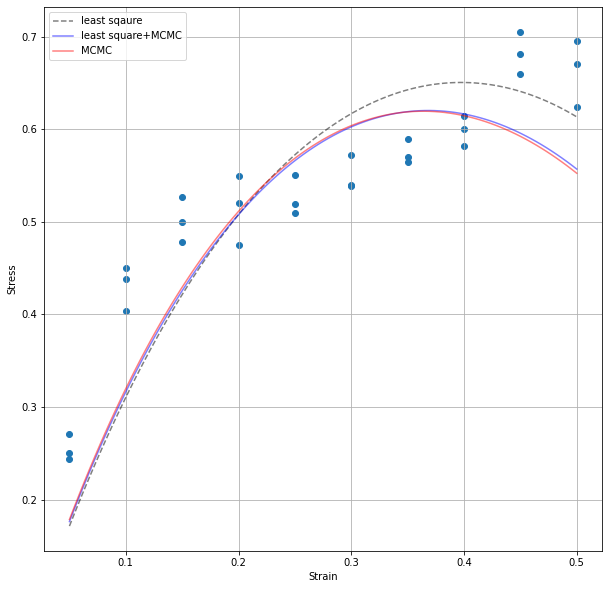

In [21]:
stress1=np.array([])
stress2=np.array([])
stress3=np.array([])
strain=np.array([])
stress1 = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/MDM project/FirstDataset_Stress1.csv",
                 delimiter=",", dtype=float)
stress2 = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/MDM project/FirstDataset_Stress2.csv",
                 delimiter=",", dtype=float)
stress3 = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/MDM project/FirstDataset_Stress3.csv",
                 delimiter=",", dtype=float)
strain = np.loadtxt("/content/gdrive/My Drive/Colab Notebooks/MDM project/FirstDataset_Strain.csv",
                 delimiter=",", dtype=float)
x = np.concatenate((stress1,stress2,stress3), axis=0)
y = np.concatenate((strain,strain,strain), axis=0)
plt.figure(figsize=(10,10))
plt.scatter(y,x)

# plot the model corresponding to the mean of the posterior distribution
x_true = np.linspace(0.05, 0.5, 101)
y_s = uniaxial_stress(MR_3D, x_true, params_opt)
y_sMCMC = uniaxial_stress(MR_3D, x_true, MLE_point1) 
y_MCMC = uniaxial_stress(MR_3D, x_true, MLE_point) 
plt.plot(x_true, y_s, "k--",label="least sqaure",alpha=0.5)
plt.plot(x_true, y_sMCMC, "b",label="least square+MCMC",alpha=0.5)
plt.plot(x_true, y_MCMC, "r",label="MCMC",alpha=0.5)

plt.legend()
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.grid()
plt.show()
